## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
# Importing standard libraries
import json
import numpy as np
import pandas as pd

# Importing libraries for text processing and NLP
import re
import nltk
import spacy
import string
nlp = spacy.load('en_core_web_sm')

# Importing visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing libraries for word clouds and text analysis
from wordcloud import WordCloud
from collections import Counter

# Importing Plotly for interactive visualizations
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

# Importing libraries for feature extraction from text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Importing machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# Importing libraries for model evaluation and training
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# For pretty-printing results
from pprint import pprint

# Libraries for time management
import time
from datetime import datetime

# For saving and loading models
import pickle

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

### Optional - Mount drive and download data for Colab

In [2]:
#'''
import glob
import os
import shutil
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive',force_remount=True)
# Define the path where you want to save the data in your Google Drive
folder_path = '/content/drive/My Drive/Ticket_Classification'
# Opening JSON file
data_path=f'{folder_path}/complaints-2021-05-14_08_16.json'
f = open(data_path,'r', encoding="utf-8")# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)
#'''

Mounted at /content/drive


### Optional - download data for Jupyter

In [3]:
'''
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json','r', encoding="utf-8")# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)
'''

'\n# Opening JSON file\nf = open(\'complaints-2021-05-14_08_16.json\',\'r\', encoding="utf-8")# Write the path to your data file and load it\n\n# returns JSON object as\n# a dictionary\ndata = json.load(f)\ndf=pd.json_normalize(data)\n'

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
print(f'Column names : {list(df.columns)}')

Column names : ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [6]:
#Check and identify pattern
pattern1=r'^_source.'
cleaned_columns=[re.sub(pattern1,'',column) for column in df.columns ]
print(cleaned_columns)
#Check and identify pattern
pattern2=r'^_'
cleaned_columns=[re.sub(pattern2,'',column) for column in cleaned_columns ]
print(cleaned_columns)

['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']
['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [7]:
#Assign new column names
df.columns=cleaned_columns
df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [8]:
print(f'Count of null values {df["complaint_what_happened"].isnull().sum()}')
print('Count of empty values' , (df["complaint_what_happened"]=='').sum())

Count of null values 0
Count of empty values 57241


In [9]:
df[df["complaint_what_happened"]==''].head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided


In [10]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"]=df["complaint_what_happened"].replace('',np.nan)
df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [11]:
#Remove all rows where complaints column is nan
df=df[~ df["complaint_what_happened"].isnull() ]
df.reset_index(drop=True, inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


### Check length of chars in complaint columns

In [12]:
df["complaint_what_happened"].str.len().describe([0.10,0.20,0.25,0.50,0.75,0.90,0.95,0.97,0.99])

,complaint_what_happened
count,21072.000000
mean,1384.006312
std,1502.196518
min,19.000000
10%,283.000000
20%,450.000000
25%,528.000000
50%,983.000000
75%,1738.000000
90%,2922.900000


#### Check columns having less chars

In [13]:
df[df["complaint_what_happened"].str.len()<20]["complaint_what_happened"]

,complaint_what_happened
5799,inquiry not removed
8697,Chase will not help


#### Check columns having more chars

In [14]:
df[df["complaint_what_happened"].str.len()>6915]["complaint_what_happened"]

,complaint_what_happened
39,I am writing you to file a complaint about an ...
82,Early in XXXX I became the XXXX XXXX of the US...
101,COMPLAINT : Chase bank has denied me from open...
111,I received an offer from Chase XXXX Visa promi...
131,"RE : Complaint Against JP Morgan Chase, XXXX H..."
...,...
20751,My husband and I have been loyal chase custome...
20763,I started a XXXX XXXX XXXX and XXXX company a...
20797,"XX/XX/XXXX I phoned Chase bank, and applied a ..."
21012,On XX/XX/XXXX there was a hail storm in XXXX X...


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text,test=False):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    if test:
        print(f'Original Text:\n{"-"*100}\n{text}\n{"="*100}')
    # Make text lowercase
    cleaned_text=text.lower()
    if test:
        print(f'After lowercase:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove text in square brackets
    pattern=r'\[*?\]'
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing square brackets:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove punctuation
    pattern=r'[%s]' % re.escape(string.punctuation)
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing punctuation:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove words containing numbers
    pattern=r'\w*\d\w*'
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing words containing numbers:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    return cleaned_text

In [16]:
#Write your function to Lemmatize the texts
def lema_text(text, test=False):
    '''Lemmatize the texts.'''
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    lema_text=" ".join(sent)
    if test:
        print(f'After Lemmatization:\n{"-"*100}\n{lema_text}\n{"="*100}')
    return lema_text

In [17]:
string_test=df.loc[1,"complaint_what_happened"]
string_test_cleaned=clean_text(string_test,test=True)

Original Text:
----------------------------------------------------------------------------------------------------
I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.
After lowercase:
----------------------------------------------------------------------------------------------------
i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.
After removing square brackets:
----------------------

In [18]:
# Efficient bulk processing using spaCy pipe
def lemmatize_texts(texts, test=False):
    """Lemmatize a list of texts."""
    # Log Start Time
    start_time=time.time()
    print("Execution Start Time : " , datetime.now())

    stopwords = nlp.Defaults.stop_words
    if test:
        print(f'Original Text:\n{"-"*100}\n{texts}\n{"="*100}')
    lemmatized = []
    for doc in nlp.pipe(texts, batch_size=1000, disable=["parser", "ner"]):
        lemmatized.append(" ".join([ token.lemma_ for token in doc if token.text not in set(stopwords) ]))
    if test:
        print(f'After Lemmatization:\n{"-"*100}\n{lemmatized}\n{"="*100}')

    # Log End time
    end_time = time.time()
    print("Execution End Time : " , datetime.now())
    # Calculate the elapsed time
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")
    return lemmatized

In [19]:
string_test_lema=lemmatize_texts([string_test_cleaned],test=True)

Execution Start Time :  2024-12-14 11:05:33.944648
Original Text:
----------------------------------------------------------------------------------------------------
['i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me']
After Lemmatization:
----------------------------------------------------------------------------------------------------
['upgrade xxxx xxxx card   tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx    change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead']
Execution End Time :  2024-12-14 11:05:33.974316
Execution time: 0.029668092727661133 seconds


In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_what_happened']]
print(df_clean.shape)

(21072, 1)


In [21]:
# Clean data
df_clean = df_clean.copy()
df_clean.loc[:,'complaint_what_happened_lemmatized']=df_clean['complaint_what_happened'].apply(lambda x: clean_text(x))

In [22]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...


In [23]:
# Apply lemmatization
df_clean = df_clean.copy()
df_clean.loc[:,'complaint_what_happened_lemmatized'] = lemmatize_texts(df_clean['complaint_what_happened_lemmatized'])

Execution Start Time :  2024-12-14 11:05:39.018111
Execution End Time :  2024-12-14 11:12:19.873739
Execution time: 400.8556258678436 seconds


In [24]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...


In [25]:
#Write your function to extract the POS tags

def pos_tag(text, test=False):
    """Extract singular nouns (NN) from text using POS tagging."""
    # Log Start Time
    start_time=time.time()
    print("Execution Start Time : " , datetime.now())

    pos_tags = []
    # Wrap the input text in a list to use `nlp.pipe`
    for doc in nlp.pipe([text], disable=["parser", "ner"]):
        for token in doc:
            if token.tag_ == "NN":  # Check if the token is a singular noun
                pos_tags.append(token.text)

    pos_tags_filtered = " ".join(pos_tags)

    if test:
        print(f'Before POS removed:\n{"-"*100}\n{text}\n{"="*100}')
        print(f'After POS removed:\n{"-"*100}\n{pos_tags_filtered}\n{"="*100}')

    # Log End time
    end_time = time.time()
    print("Execution End Time : " , datetime.now())
    # Calculate the elapsed time
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    return pos_tags_filtered

In [26]:
string_test=df_clean.loc[1,"complaint_what_happened_lemmatized"]
string_test_POS_removed=pos_tag(string_test,test=True)

Execution Start Time :  2024-12-14 11:12:20.260998
Before POS removed:
----------------------------------------------------------------------------------------------------
upgrade xxxx xxxx card   tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx    change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead
After POS removed:
----------------------------------------------------------------------------------------------------
card agent upgrade anniversary date change agent information order account anniversary date agent
Execution End Time :  2024-12-14 11:12:20.268446
Execution time: 0.0074481964111328125 seconds


In [27]:
df_clean = df_clean.copy()
# This column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"]
df_clean.loc[:,'complaint_POS_removed'] = df_clean['complaint_what_happened_lemmatized'].apply(lambda x: pos_tag(x))

Streaming output truncated to the last 5000 lines.
Execution End Time :  2024-12-14 11:16:40.431855
Execution time: 0.008042097091674805 seconds
Execution Start Time :  2024-12-14 11:16:40.431970
Execution End Time :  2024-12-14 11:16:40.438230
Execution time: 0.006259918212890625 seconds
Execution Start Time :  2024-12-14 11:16:40.438367
Execution End Time :  2024-12-14 11:16:40.446613
Execution time: 0.008246421813964844 seconds
Execution Start Time :  2024-12-14 11:16:40.446718
Execution End Time :  2024-12-14 11:16:40.452089
Execution time: 0.0053708553314208984 seconds
Execution Start Time :  2024-12-14 11:16:40.452200
Execution End Time :  2024-12-14 11:16:40.475315
Execution time: 0.02311539649963379 seconds
Execution Start Time :  2024-12-14 11:16:40.475426
Execution End Time :  2024-12-14 11:16:40.492571
Execution time: 0.017145395278930664 seconds
Execution Start Time :  2024-12-14 11:16:40.492682
Execution End Time :  2024-12-14 11:16:40.519009
Execution time: 0.026327371597

In [28]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...


### Optional - Save cleaned data(.csv) in drive for Colab

In [29]:
#'''
import glob
import os
import shutil
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive',force_remount=True)
# Define the path where you want to save the data in your Google Drive
consolidated_folder = f'{folder_path}/data'
# Path to the CSV file where want to copy
df_clean.to_csv('df_clean.csv')
source_file = '/content/df_clean.csv'
# Step 1: Check if the consolidated folder exists
if os.path.exists(consolidated_folder):
    # If it exists, delete the folder and its contents
    shutil.rmtree(consolidated_folder)
    print(f"{consolidated_folder} folder has been deleted.")
else:
    print(f"{consolidated_folder} folder does not exist.")
# Create the consolidated folder
os.makedirs(consolidated_folder, exist_ok=True)
# Step 2: Copy the file to the consolidated destination
shutil.copy(source_file, os.path.join(consolidated_folder, os.path.basename(source_file)))
print(f"File {source_file} has been copied to {consolidated_folder}.")
#'''

Mounted at /content/drive
/content/drive/My Drive/Ticket_Classification/data folder has been deleted.
File /content/df_clean.csv has been copied to /content/drive/My Drive/Ticket_Classification/data.


In [18]:
df_clean=pd.read_csv('df_clean.csv')
df_clean.drop(columns=['Unnamed: 0'],inplace=True)
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...


In [19]:
df_clean[df_clean["complaint_POS_removed"].isnull()]

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
58,ChaseMortgagehasautomaticallydeducted2mortgage...,NaN,NaN
1487,Please forward the information to J.P Morgan C...,forward information jp morgan chase bank thank,NaN
1619,Did not inquire this,inquire,NaN
1931,I keep getting billed for lock box with chase ...,get bill lock box chase not,NaN
2813,IreceivedanemailXX/XX/XXXXthatmycreditcardswer...,\n\n\n\n\n,NaN
3194,IacceptedapromotionalofferonmyChaseSapphirecre...,NaN,NaN
4988,Throughoutthelastfewmonthswehavehadawebsite(XX...,NaN,NaN
5629,XXXX BANK XXXX {$140.00} {$200.00} 71 % Revolv...,xxxx bank xxxx revolve negative xxxx xxxx...,NaN
7741,"OnmyXXXXXXXX,XXXXstatement,Ihad{$0.00}purchase...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n myxxxxxxxxxxxxsta...,NaN
9887,I want to know what involvement JP Morgan has ...,want know involvement jp morgan mortgage,NaN


In [20]:
#Remove all rows where complaints column is nan
df_clean=df_clean[~ df_clean["complaint_POS_removed"].isnull() ]
df_clean.reset_index(drop=True, inplace=True)

In [21]:
df_clean[df_clean["complaint_POS_removed"].isnull()]

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




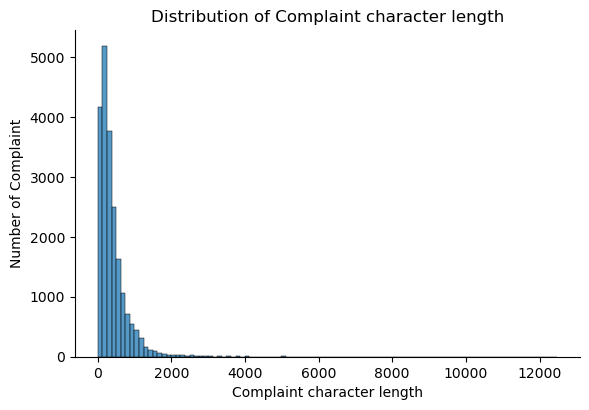

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_lens=df_clean["complaint_POS_removed"].str.len()
sns.displot(complaint_lens,bins=100,height=4, aspect=1.5)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

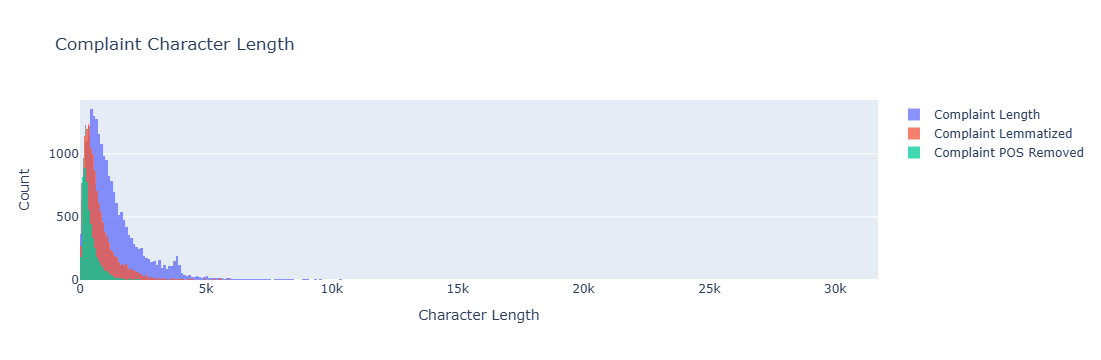

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean = df_clean.copy()
df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['complaint_what_happened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()


fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint Length'))
fig.add_trace(go.Histogram(x=df_clean['complaint_what_happened_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

In [24]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

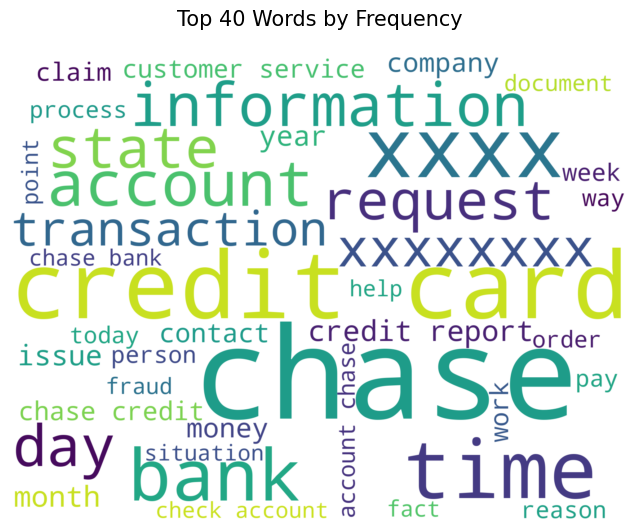

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stopwords = nlp.Defaults.stop_words
wordcloud=WordCloud(stopwords= stopwords, background_color='white', width=2000, height=1500, max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
# Display the Word Cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.title("Top 40 Words by Frequency\n", fontsize=15)
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
unigram = get_top_n_words(df_clean['complaint_clean'], 1,30)
words_freq_df = pd.DataFrame(unigram, columns = ['unigram' , 'unigram_freq'])
px.bar(x=words_freq_df['unigram'], y=words_freq_df['unigram_freq'], title='Top 30 Unigrams')

In [28]:
#Print the top 10 words in the unigram frequency
words_freq_df.head(10)

,unigram,unigram_freq
0,chase,54043
1,account,41339
2,credit,33612
3,xxxx,33326
4,card,29904
5,payment,21108
6,bank,17559
7,time,15919
8,charge,15350
9,day,12913


In [29]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram = get_top_n_words(df_clean['complaint_clean'], 2,30)
words_freq_df['bigram'] = [word for word, freq in bigram]
words_freq_df['bigram_freq'] = [freq for word, freq in bigram]
px.bar(x=words_freq_df['bigram'], y=words_freq_df['bigram_freq'], title='Top 30 Bigrams')

In [30]:
#Print the top 10 words in the bigram frequency
words_freq_df.head(10)

,unigram,unigram_freq,bigram,bigram_freq
0,chase,54043,credit card,12789
1,account,41339,credit report,3904
2,credit,33612,chase credit,3085
3,xxxx,33326,customer service,2931
4,card,29904,account chase,2470
5,payment,21108,chase bank,2185
6,bank,17559,check account,2143
7,time,15919,xxxx xxxx,2117
8,charge,15350,chase account,2045
9,day,12913,contact chase,1926


In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram = get_top_n_words(df_clean['complaint_clean'], 3,30)
words_freq_df['trigram'] = [word for word, freq in trigram]
words_freq_df['trigram_freq'] = [freq for word, freq in trigram]
px.bar(x=words_freq_df['trigram'], y=words_freq_df['trigram_freq'], title='Top 30 Trigram')

In [32]:
#Print the top 10 words in the trigram frequency
words_freq_df.head(10)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq
0,chase,54043,credit card,12789,chase credit card,2211
1,account,41339,credit report,3904,credit card account,1051
2,credit,33612,chase credit,3085,credit card company,977
3,xxxx,33326,customer service,2931,credit card chase,747
4,card,29904,account chase,2470,xxxx credit card,679
5,payment,21108,chase bank,2185,chase customer service,563
6,bank,17559,check account,2143,inquiry credit report,486
7,time,15919,xxxx xxxx,2117,credit card credit,431
8,charge,15350,chase account,2045,credit card xxxx,414
9,day,12913,contact chase,1926,charge credit card,406


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [34]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,486,300,147,morning help bank service chase debt verificat...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...,355,210,97,card agent upgrade anniversary date change age...
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...,224,134,101,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...,1502,762,411,book ticket come offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,477,284,167,son deposit chase account fund bank account pa...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Write your code here to initialise the TfidfVectorizer
tf_idf_vec = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf=tf_idf_vec.fit_transform(df_clean['complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

## Coherence Model to select best number of Topics
With the Coherence Model we will see how to automatically select the best number of topics.


In [38]:
'''
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_clean']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)
'''

'\nimport warnings\nwarnings.filterwarnings("ignore")\nfrom gensim.corpora.dictionary import Dictionary\nfrom gensim.models.nmf import Nmf\nfrom gensim.models.coherencemodel import CoherenceModel\nfrom operator import itemgetter\n# Use Gensim\'s NMF to get the best num of topics via coherence score\ntexts = df_clean[\'complaint_clean\']\ndataset = [d.split() for d in texts]\n\n# Create a dictionary\n# In gensim a dictionary is a mapping between words and their integer id\ndictionary = Dictionary(dataset)\n\n# Filter out extremes to limit the number of features\ndictionary.filter_extremes(\n    no_below=3,\n    no_above=0.85,\n    keep_n=5000\n)\n\n# Create the bag-of-words format (list of (token_id, token_count))\ncorpus = [dictionary.doc2bow(text) for text in dataset]\n\n# Create a list of the topic numbers we want to try\ntopic_nums = list(np.arange(5, 10, 1))\n\n# Run the nmf model and calculate the coherence score\n# for each number of topics\ncoherence_scores = []\n\nfor num in to

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [39]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [40]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out())

6507

In [41]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'bank', 'money', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['time', 'reason', 'service', 'application', 'month', 'point', 'purchase', 'year', 'limit', 'score', 'account', 'balance', 'chase', 'credit', 'card']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['date', 'statement', 'property', 'balance', 'rate', 'year', 'pay', 'time', 'home', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['letter', 'score', 'dispute', 'theft', 'remove', 'file', 'identity', 'account', 'reporting', 'debt', 'information', 'company', 'credit', 'inquiry', 'report']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['statement', 'time', 'contact', 'email', 'service', 'fraud', 'refund', 'purchase', 'claim', 'merchant', 'transaction', 'chase', 'fee', 'disp

In [42]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([0, 1, 3, ..., 3, 1, 2], dtype=int64)

In [43]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1)#write your code to assign topics to each rows.

In [44]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,486,300,147,morning help bank service chase debt verificat...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...,355,210,97,card agent upgrade anniversary date change age...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...,224,134,101,chase card report application submit identity ...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...,1502,762,411,book ticket come offer ticket reward card info...,3
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,477,284,167,son deposit chase account fund bank account pa...,0


In [45]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values(by='Topic')

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,486,300,147,morning help bank service chase debt verificat...,0
10,mishandling of this account by Chase auto and ...,mishandle account chase auto xxxx,mishandle account chase auto xxxx,51,33,33,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...,account debit card branch customer service rep...,2277,1245,630,account debit card branch customer service rep...,0
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,477,284,167,son deposit chase account fund bank account pa...,0
12,I opened an account with chase bank on XXXX an...,open account chase bank xxxx code xxxx bonus c...,account follow xxxxxxxx term account xxxx depo...,413,192,106,account follow term account deposit bonus da...,0
14,My chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,catering order place brother funeral contact c...,1972,1040,569,catering order place brother funeral contact c...,1
25,I currently have over XXXX Chase Ultimate Rewa...,currently xxxx chase ultimate reward point wor...,xxxx reward point month access chase reward ac...,1897,1045,556,reward point month access chase reward accoun...,1
22,My roommate was stealing my Chase debit card a...,roommate steal chase debit card driver license...,roommate chase debit card driver license money...,843,459,239,roommate chase debit card driver license money...,1
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...,355,210,97,card agent upgrade anniversary date change age...,1
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,senior citizen scamme company xxxx xxxx pay ...,citizen time share company misleading refund c...,350,133,76,citizen time share company misleading refund c...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [46]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)

In [47]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic,Topic_category
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,486,300,147,morning help bank service chase debt verificat...,0,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...,355,210,97,card agent upgrade anniversary date change age...,1,Credit card or prepaid card
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...,224,134,101,chase card report application submit identity ...,3,Theft/Dispute Reporting
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...,1502,762,411,book ticket come offer ticket reward card info...,3,Theft/Dispute Reporting
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,477,284,167,son deposit chase account fund bank account pa...,0,Bank Account services


### Optional - Save cleaned topics data(.csv) in drive for Colab

In [74]:
#'''
# Define the path where you want to save the data in your Google Drive
consolidated_folder = f'{folder_path}/data'
# Path to the CSV file where want to copy
df_clean.to_csv('df_clean_topics.csv')
source_file = '/content/df_clean_topics.csv'
# Create the consolidated folder
os.makedirs(consolidated_folder, exist_ok=True)
# Step 2: Copy the file to the consolidated destination
shutil.copy(source_file, os.path.join(consolidated_folder, os.path.basename(source_file)))
print(f"File {source_file} has been copied to {consolidated_folder}.")
#'''

File /content/df_clean_topics.csv has been copied to /content/drive/My Drive/Ticket_Classification/data.


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [63]:
df_clean=pd.read_csv('df_clean_topics.csv')
df_clean.drop(columns=['Unnamed: 0'],inplace=True)
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic,Topic_category
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,486,300,147,morning help bank service chase debt verificat...,0,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...,355,210,97,card agent upgrade anniversary date change age...,1,Credit card or prepaid card
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...,224,134,101,chase card report application submit identity ...,3,Theft/Dispute Reporting
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...,1502,762,411,book ticket come offer ticket reward card info...,3,Theft/Dispute Reporting
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,477,284,167,son deposit chase account fund bank account pa...,0,Bank Account services


In [64]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [65]:
# Set maximum column width
pd.set_option('display.max_colwidth', None)
display(training_data)

# Reset to the default value
pd.reset_option('display.max_colwidth')

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",3
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",3
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0
...,...,...
21054,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved for all ( 3 ) new cards with No annual fee for 1st year. After less than 2 months with payment always paid as agreed, Chase closed all my cards. One of my ( 3 ) approved new cards was never activated but was sent to me.\n\nChase has done harm to my credit, has charged me an annual fee even though they cancelled my account, failed to credit my points for both airlines and hotel, failed to credit up to {$100.00} for XXXX enrollment and failed to credit airline charge as agreed upon",1
21055,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three hig

In [66]:
training_data['Topic'].value_counts()

Topic
0    5194
2    5102
4    4444
1    3962
3    2357
Name: count, dtype: int64

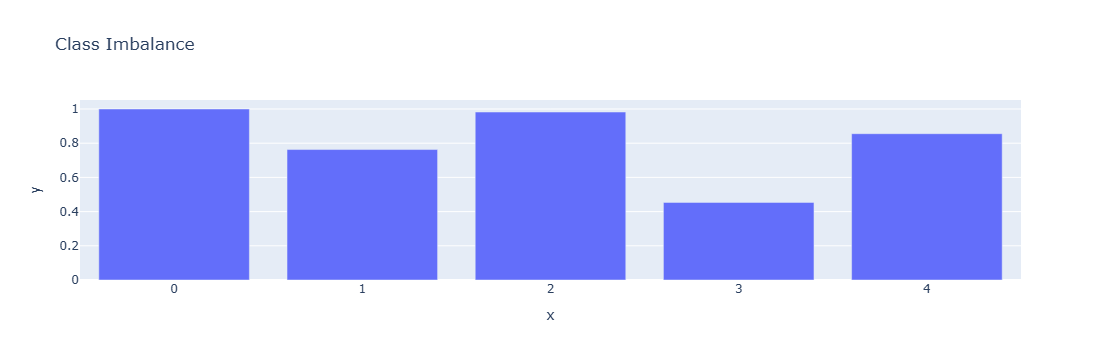

In [67]:
# Checking for class imbalance
px.bar(x=training_data['Topic'].value_counts().index, y=training_data['Topic'].value_counts().values/max(training_data['Topic'].value_counts().values), title='Class Imbalance')

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [68]:
# Get Vector Count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

# Save Word Vector
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [69]:
# Transform  Word Vector to TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Save TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [70]:
# Prepare the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=40)

### Custom functions

In [71]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    # Log Start Time
    start_time=time.time()
    print("Execution Start Time : " , datetime.now())
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid=param_grid,cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(X_train,y_train)
    # Log End time
    end_time = time.time()
    print("Execution End Time : " , datetime.now())
    # Calculate the elapsed time
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")
    return grid.best_estimator_

In [72]:
# function to update evaluation metrics
def update_evaluation(model,model_summary,accuracy,precision,recall,f1score,rocaucscore) :
    # Create a single dictionary to store all metrics
    evaluation_metrics = {
        "Estimator":str(model),
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score":f1score,
        "ROC_AUC_Score": rocaucscore
    }
    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame([evaluation_metrics])
    # If model_summary is empty, initialize it with the first metrics_df
    if model_summary.empty:
        model_summary = metrics_df
    else:
      if model not in list(model_summary["Estimator"]) :
        # Concatenate the new DataFrame with the existing model_summary DataFrame
        model_summary = pd.concat([model_summary, metrics_df], axis=0, ignore_index=True)
    # Reset Index
    model_summary.reset_index(inplace=True,drop=True)
    # Return out the model_summary for verification
    return model_summary

In [73]:
# function to evaluate the model and display the results
def eval_model(model,model_summary,y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    # Calculate Metrics
    accuracy=round( accuracy_score(y_test,y_pred),2)
    precision=round( precision_score(y_test,y_pred,average='weighted'),2)
    recall=round( recall_score(y_test,y_pred,average='weighted'),2)
    f1score=round(f1_score(y_test,y_pred,average='weighted'),2)
    rocaucscore=round(roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr'),2)
    # Print Metrics
    print('Accuracy: ', accuracy )
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 Score: ', f1score)
    print('ROC AUC Score: ', rocaucscore)
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    # Plot and show the confusion matrix
    disp.plot(cmap='viridis')
    plt.show()
    if type=='Test':
        model_summary=update_evaluation(model,model_summary,accuracy,precision,recall,f1score,rocaucscore)
    # Return out the model_summary for verification
    return model_summary

### 1. Logistic Regression

In [76]:
# Initialize model_summary as an empty DataFrame with the required columns
model_summary = pd.DataFrame(columns=['Estimator', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC_Score'])

Execution Start Time :  2024-12-14 13:30:23.898528
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Execution End Time :  2024-12-14 13:46:15.656338
Execution time: 951.7578101158142 seconds
Training results
Accuracy:  0.94
Precision:  0.94
Recall:  0.94
F1 Score:  0.94
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.95      0.93      0.94      4158
           1       0.94      0.94      0.94      3164
           2       0.97      0.96      0.96      4052
           3       0.89      0.96      0.93      1911
           4       0.93      0.92      0.92      3562

    accuracy                           0.94     16847
   macro avg       0.94      0.94      0.94     16847
weighted avg       0.94      0.94      0.94     16847



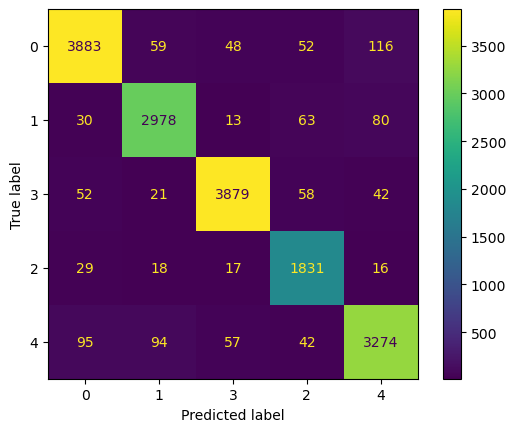

Test results
Accuracy:  0.93
Precision:  0.93
Recall:  0.93
F1 Score:  0.93
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.94      0.94      0.94      1036
           1       0.93      0.92      0.93       798
           2       0.95      0.95      0.95      1050
           3       0.87      0.94      0.90       446
           4       0.92      0.90      0.91       882

    accuracy                           0.93      4212
   macro avg       0.92      0.93      0.93      4212
weighted avg       0.93      0.93      0.93      4212



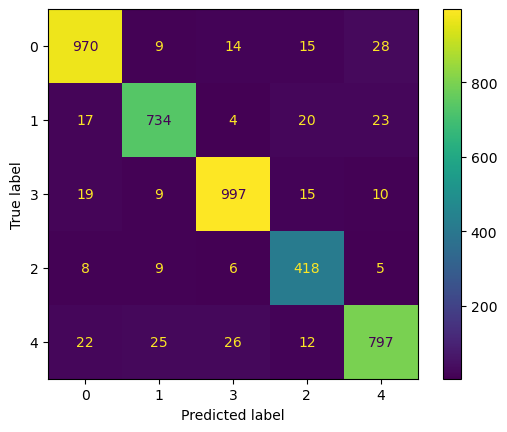

                                           Estimator  Accuracy  Precision  \
0  LogisticRegression(C=1, class_weight='balanced...      0.93       0.93   

   Recall  F1_Score  ROC_AUC_Score  
0    0.93      0.93           0.99  


In [77]:
#running and evaluating the Logistic Regression model
params = {
    'C': [ 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [ 100, 200, 300 ] ,
    'class_weight': [None, 'balanced']
}
model=run_model(LogisticRegression(random_state=40),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
# Save Model
pickle.dump(model, open("lr_model.pkl", "wb"))

### 2. Decision Tree

Execution Start Time :  2024-12-14 13:46:16.694547
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Execution End Time :  2024-12-14 13:52:09.567965
Execution time: 352.87341809272766 seconds
Training results
Accuracy:  0.89
Precision:  0.89
Recall:  0.89
F1 Score:  0.89
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.90      0.90      0.90      4158
           1       0.91      0.91      0.91      3164
           2       0.94      0.90      0.92      4052
           3       0.91      0.84      0.87      1911
           4       0.82      0.89      0.85      3562

    accuracy                           0.89     16847
   macro avg       0.89      0.89      0.89     16847
weighted avg       0.89      0.89      0.89     16847



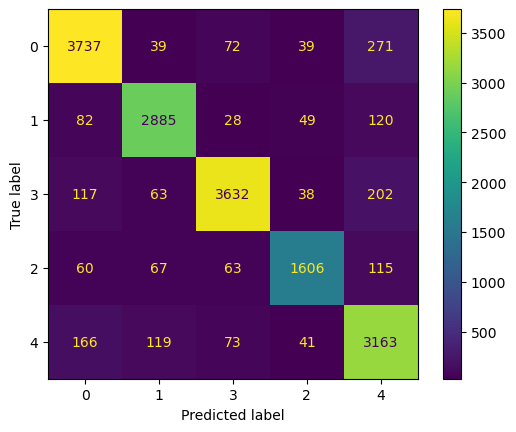

Test results
Accuracy:  0.78
Precision:  0.78
Recall:  0.78
F1 Score:  0.78
ROC AUC Score:  0.89
Classification Report:                precision    recall  f1-score   support

           0       0.79      0.79      0.79      1036
           1       0.79      0.79      0.79       798
           2       0.86      0.83      0.85      1050
           3       0.75      0.71      0.73       446
           4       0.68      0.74      0.71       882

    accuracy                           0.78      4212
   macro avg       0.78      0.77      0.77      4212
weighted avg       0.78      0.78      0.78      4212



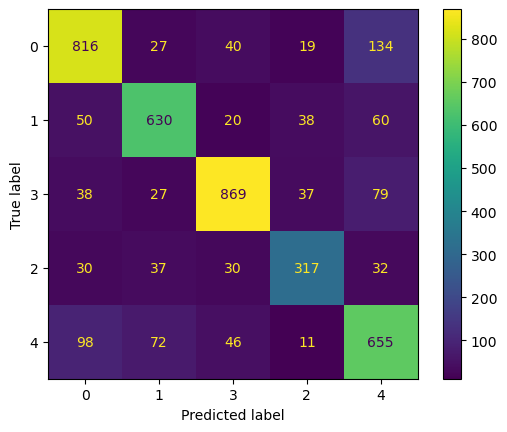

                                           Estimator  Accuracy  Precision  \
0  LogisticRegression(C=1, class_weight='balanced...      0.93       0.93   
1  DecisionTreeClassifier(max_depth=20, min_sampl...      0.78       0.78   

   Recall  F1_Score  ROC_AUC_Score  
0    0.93      0.93           0.99  
1    0.78      0.78           0.89  


In [78]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': [None, 'sqrt', 'log2']
}
model=run_model(DecisionTreeClassifier(random_state=40),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
# Save Model
pickle.dump(model, open("dtree_model.pkl", "wb"))

### 3. Random Forest

Execution Start Time :  2024-12-14 13:52:10.889919
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Execution End Time :  2024-12-14 14:56:35.479929
Execution time: 3864.5900099277496 seconds
Training results
Accuracy:  0.99
Precision:  0.99
Recall:  0.99
F1 Score:  0.99
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      4158
           1       1.00      0.99      1.00      3164
           2       0.99      1.00      0.99      4052
           3       0.98      0.98      0.98      1911
           4       1.00      0.99      0.99      3562

    accuracy                           0.99     16847
   macro avg       0.99      0.99      0.99     16847
weighted avg       0.99      0.99      0.99     16847



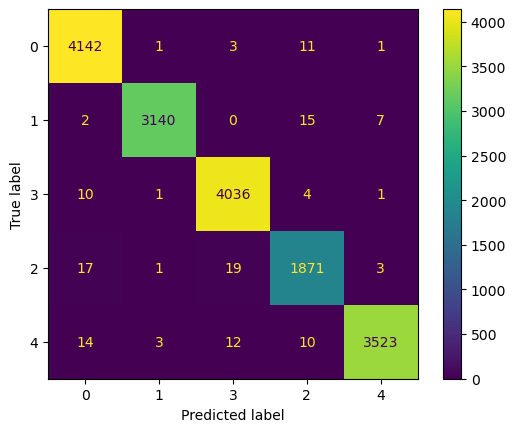

Test results
Accuracy:  0.83
Precision:  0.83
Recall:  0.83
F1 Score:  0.83
ROC AUC Score:  0.97
Classification Report:                precision    recall  f1-score   support

           0       0.79      0.91      0.85      1036
           1       0.83      0.73      0.78       798
           2       0.85      0.90      0.88      1050
           3       0.91      0.71      0.80       446
           4       0.82      0.79      0.80       882

    accuracy                           0.83      4212
   macro avg       0.84      0.81      0.82      4212
weighted avg       0.83      0.83      0.83      4212



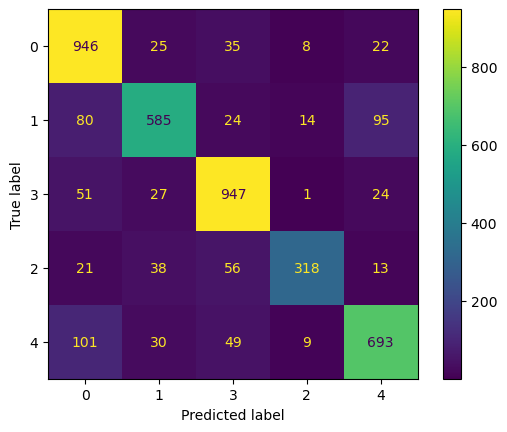

                                           Estimator  Accuracy  Precision  \
0  LogisticRegression(C=1, class_weight='balanced...      0.93       0.93   
1  DecisionTreeClassifier(max_depth=20, min_sampl...      0.78       0.78   
2  RandomForestClassifier(min_samples_leaf=2, min...      0.83       0.83   

   Recall  F1_Score  ROC_AUC_Score  
0    0.93      0.93           0.99  
1    0.78      0.78           0.89  
2    0.83      0.83           0.97  


In [79]:
#running and evaluating the Random Forest model
params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [ None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'bootstrap': [True]
}
model=run_model(RandomForestClassifier(random_state=40),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
# Save Model
pickle.dump(model, open("rf_model.pkl", "wb"))

### 4. Multinomial Naive Bayes

Execution Start Time :  2024-12-14 14:56:49.031014
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Execution End Time :  2024-12-14 14:56:50.362648
Execution time: 1.3316338062286377 seconds
Training results
Accuracy:  0.86
Precision:  0.86
Recall:  0.86
F1 Score:  0.86
ROC AUC Score:  0.98
Classification Report:                precision    recall  f1-score   support

           0       0.85      0.91      0.88      4158
           1       0.84      0.79      0.81      3164
           2       0.90      0.88      0.89      4052
           3       0.81      0.85      0.83      1911
           4       0.85      0.83      0.84      3562

    accuracy                           0.86     16847
   macro avg       0.85      0.85      0.85     16847
weighted avg       0.86      0.86      0.86     16847



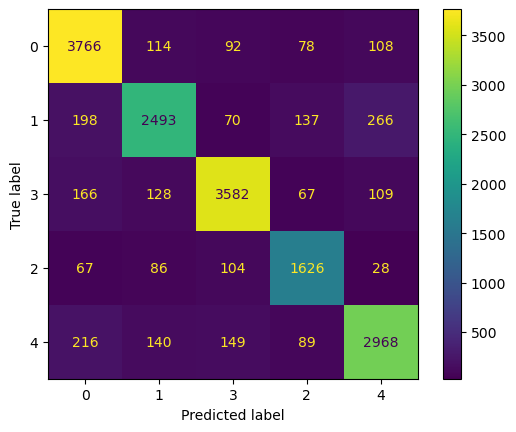

Test results
Accuracy:  0.76
Precision:  0.76
Recall:  0.76
F1 Score:  0.76
ROC AUC Score:  0.94
Classification Report:                precision    recall  f1-score   support

           0       0.76      0.83      0.79      1036
           1       0.70      0.65      0.67       798
           2       0.83      0.82      0.82      1050
           3       0.74      0.71      0.73       446
           4       0.74      0.74      0.74       882

    accuracy                           0.76      4212
   macro avg       0.75      0.75      0.75      4212
weighted avg       0.76      0.76      0.76      4212



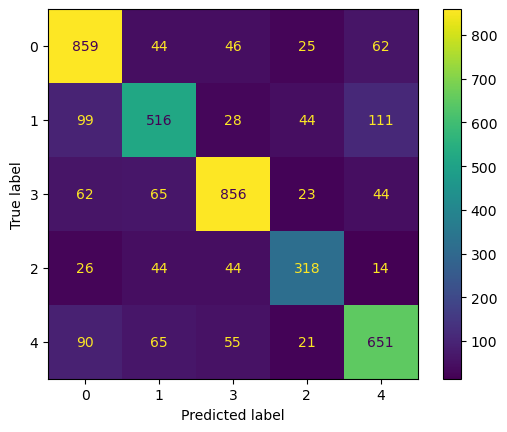

                                           Estimator  Accuracy  Precision  \
0  LogisticRegression(C=1, class_weight='balanced...      0.93       0.93   
1  DecisionTreeClassifier(max_depth=20, min_sampl...      0.78       0.78   
2  RandomForestClassifier(min_samples_leaf=2, min...      0.83       0.83   
3          MultinomialNB(alpha=0.1, fit_prior=False)      0.76       0.76   

   Recall  F1_Score  ROC_AUC_Score  
0    0.93      0.93           0.99  
1    0.78      0.78           0.89  
2    0.83      0.83           0.97  
3    0.76      0.76           0.94  


In [80]:
#running and evaluating the Gaussian Naive Bayes model
params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}
model=run_model(MultinomialNB(),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
# Save Model
pickle.dump(model, open("nb_model.pkl", "wb"))

### 5. XGBoost Classifier

Execution Start Time :  2024-12-14 14:56:51.799015
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Execution End Time :  2024-12-14 16:26:43.068645
Execution time: 5391.269629478455 seconds
Training results
Accuracy:  0.98
Precision:  0.98
Recall:  0.98
F1 Score:  0.98
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.98      0.98      0.98      4158
           1       0.99      0.99      0.99      3164
           2       0.99      0.98      0.99      4052
           3       0.99      0.98      0.98      1911
           4       0.98      0.98      0.98      3562

    accuracy                           0.98     16847
   macro avg       0.98      0.98      0.98     16847
weighted avg       0.98      0.98      0.98     16847



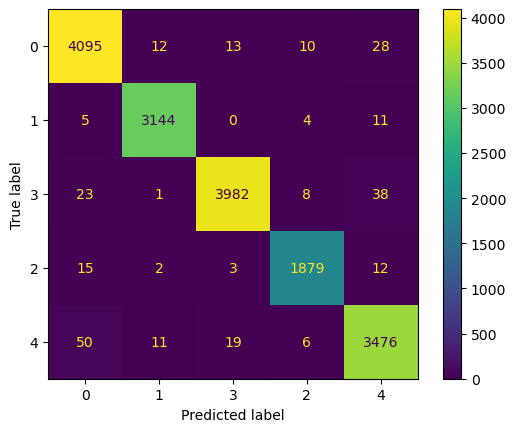

Test results
Accuracy:  0.9
Precision:  0.9
Recall:  0.9
F1 Score:  0.9
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.90      0.91      0.91      1036
           1       0.90      0.90      0.90       798
           2       0.92      0.93      0.93      1050
           3       0.87      0.85      0.86       446
           4       0.87      0.86      0.86       882

    accuracy                           0.90      4212
   macro avg       0.89      0.89      0.89      4212
weighted avg       0.90      0.90      0.90      4212



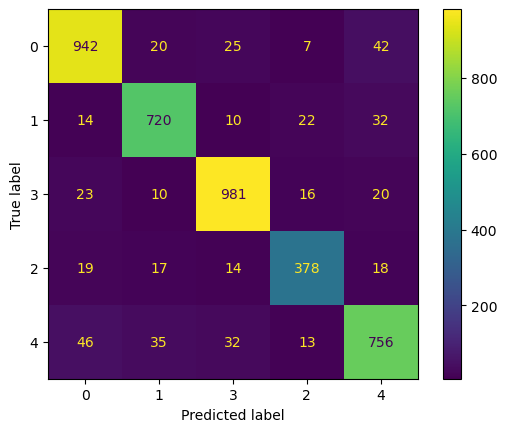

                                           Estimator  Accuracy  Precision  \
0  LogisticRegression(C=1, class_weight='balanced...      0.93       0.93   
1  DecisionTreeClassifier(max_depth=20, min_sampl...      0.78       0.78   
2  RandomForestClassifier(min_samples_leaf=2, min...      0.83       0.83   
3          MultinomialNB(alpha=0.1, fit_prior=False)      0.76       0.76   
4  XGBClassifier(base_score=None, booster=None, c...      0.90       0.90   

   Recall  F1_Score  ROC_AUC_Score  
0    0.93      0.93           0.99  
1    0.78      0.78           0.89  
2    0.83      0.83           0.97  
3    0.76      0.76           0.94  
4    0.90      0.90           0.99  


In [81]:
#running and evaluating the XGBoost model
params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'gamma': [0, 1],
}
model=run_model(XGBClassifier(random_state=40,n_jobs=-1, verbosity=2),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
# Save Model
pickle.dump(model, open("xgb_model.pkl", "wb"))

## Check Results and Conclusions

In [82]:
# Set maximum column width
pd.set_option('display.max_colwidth', None)
display(model_summary)
# Reset to the default value
pd.reset_option('display.max_colwidth')


,Estimator,Accuracy,Precision,Recall,F1_Score,ROC_AUC_Score
0,"LogisticRegression(C=1, class_weight='balanced', max_iter=200, penalty='l1',\n random_state=40, solver='saga')",0.93,0.93,0.93,0.93,0.99
1,"DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=5,\n random_state=40)",0.78,0.78,0.78,0.78,0.89
2,"RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,\n n_estimators=200, random_state=40)",0.83,0.83,0.83,0.83,0.97
3,"MultinomialNB(alpha=0.1, fit_prior=False)",0.76,0.76,0.76,0.76,0.94
4,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=0, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=0.1, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=100, n_jobs=-1,\n num_parallel_tree=None, objective='multi:softprob', ...)",0.90,0.90,0.90,0.90,0.99


### Optional - Save model and data in Drive for Colab

In [84]:
'''
# Define source folder
source_folder = '/content'
# Define destination folder
consolidated_folder = f'{folder_path}/files'
# Ensure the destination folder exists
os.makedirs(consolidated_folder, exist_ok=True)
for file_name in os.listdir(source_folder):
    # Check if the file has a .csv or .pkl extension
    if file_name.endswith('.csv') or file_name.endswith('.pkl'):
        source_file = os.path.join(source_folder, file_name)  # Full path of source file
        destination_file = os.path.join(consolidated_folder, file_name)  # Full path of destination file
        # Copy the file to the consolidated folder
        shutil.copy(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")
print("All .csv and .pkl files have been copied.")
'''

'\n# Define source folder\nsource_folder = \'/content\'\n# Define destination folder\nconsolidated_folder = f\'{folder_path}/files\'\n# Ensure the destination folder exists\nos.makedirs(consolidated_folder, exist_ok=True)\nfor file_name in os.listdir(source_folder):\n    # Check if the file has a .csv or .pkl extension\n    if file_name.endswith(\'.csv\') or file_name.endswith(\'.pkl\'):\n        source_file = os.path.join(source_folder, file_name)  # Full path of source file\n        destination_file = os.path.join(consolidated_folder, file_name)  # Full path of destination file\n        # Copy the file to the consolidated folder\n        shutil.copy(source_file, destination_file)\n        print(f"Copied {source_file} to {destination_file}")\nprint("All .csv and .pkl files have been copied.")\n'

## Evaluation and Results

In [125]:
complaint_list=["I can not get from chase who services my mortgage, who owns it and who has original loan doc.",
                "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                "I noticed a theft transaction on my account.",
                "What is the procedure to know my CIBIL score?",
                "I need to know the number of bank branches and their locations in the city of Dubai"]

df_complaints = pd.DataFrame({'complaints': complaint_list})
# Set maximum column width
pd.set_option('display.max_colwidth', None)
display(df_complaints)
# Reset to the default value
pd.reset_option('display.max_colwidth')

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan doc."
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,I noticed a theft transaction on my account.
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and their locations in the city of Dubai


In [126]:
def predict_topics(texts):
    """
    Predict topics for given input texts.

    Args:
        texts (list of str): A list of text inputs to predict topics for.

    Returns:
        list of str: Predicted topic names for each input text.
    """
    # Define topic mapping
    Topic_names = {
        0: 'Bank Account services',
        1: 'Credit card or prepaid card',
        2: 'Mortgage/Loan',
        3: 'Theft/Dispute Reporting',
        4: 'Others'
    }
    try:
        # Load pre-trained models and transformers
        loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
        loaded_tfidf = pickle.load(open("tfidf.pkl", "rb"))
        loaded_model = pickle.load(open("lr_model.pkl", "rb"))
        # Transform input data
        X_new_counts = loaded_vec.transform(texts)
        X_new_tfidf = loaded_tfidf.transform(X_new_counts)
        # Predict topics
        predicted = loaded_model.predict(X_new_tfidf)
        # Map predictions to topic names
        predicted_topics = [Topic_names[label] for label in predicted]
        return predicted_topics[0]
    except Exception as e:
        print(f"Error during prediction: {e}")
        return []

In [127]:
df_complaints['predicted_topics_names'] = df_complaints['complaints'].apply(lambda x: predict_topics([x]))

In [128]:
# Set maximum column width
pd.set_option('display.max_colwidth', None)
display(df_complaints)
# Reset to the default value
pd.reset_option('display.max_colwidth')


,complaints,predicted_topics_names
0,"I can not get from chase who services my mortgage, who owns it and who has original loan doc.",Mortgage/Loan
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit card or prepaid card
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank Account services
3,I noticed a theft transaction on my account.,Bank Account services
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,I need to know the number of bank branches and their locations in the city of Dubai,Bank Account services


## Technologies/Libraries Used

In [129]:
import sys
import nltk
import spacy
import matplotlib
import plotly
import sklearn
# Print versions for all libraries
print("Library Versions:")
print(f"Python: {sys.version.split()[0]}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"NLTK: {nltk.__version__}")
print(f"SpaCy: {spacy.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Plotly: {plotly.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Library Versions:
Python: 3.12.3
Numpy: 1.26.4
Pandas: 2.2.2
NLTK: 3.9.1
SpaCy: 3.8.2
Seaborn: 0.13.2
Matplotlib: 3.9.2
Plotly: 5.24.1
Scikit-learn: 1.5.1


# <div align="center"> ---------  End of Notebook ----------- </div>